<a href="https://colab.research.google.com/github/dineshnain00/SAIKET-INTERNSHIP-TASK/blob/main/Saiket_internship_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.impute import SimpleImputer

# Optional: for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    smote_available = False

# ---------- CONFIG ----------
DATA_PATH = "/content/Telco_Customer_Churn_Dataset  (1).csv"  # change if needed
RANDOM_STATE = 42

# ---------- 1) Load data ----------
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())

# ---------- 1.1) Quick overview ----------
print("\n--- Info ---")
df.info()
print("\n--- Describe numeric ---")
display(df.describe(include=[np.number]).T)
print("\n--- Describe object ---")
display(df.describe(include=['object']).T)

# ---------- 1.2) Basic cleaning: strip spaces and unify column names ----------
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
# Example: if 'TotalCharges' read as object, convert after cleaning
print("Columns:", df.columns.tolist())

# ---------- 1.3) Handle common issues ----------
# Some Telco CSVs have TotalCharges as object due to spaces -> coerce to numeric
if 'totalcharges' in df.columns and df['totalcharges'].dtype == object:
    df['totalcharges'] = pd.to_numeric(df['totalcharges'].str.strip(), errors='coerce')

# Convert customerID-like column to string
id_col_candidates = [c for c in df.columns if 'customer' in c]
if id_col_candidates:
    df[id_col_candidates[0]] = df[id_col_candidates[0]].astype(str)

# ---------- 1.4) Missing values ----------
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing[missing > 0])

# Strategy:
# - For numeric missing (e.g., totalcharges), fill with 0 or median as appropriate.
# - For categorical missing, fill with 'Unknown' or mode.
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Fill numeric missing with median (except id)
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Fill categorical with mode
for c in cat_cols:
    if c not in id_col_candidates:
        mode_val = df[c].mode().iloc[0] if not df[c].mode().empty else 'Unknown'
        df[c] = df[c].fillna(mode_val)

print("\nAfter imputation missing values:\n", df.isna().sum().sum())

# ---------- 1.5) Convert target 'churn' to binary ----------
# Common names: 'Churn' or 'churn'
target_col = None
for name in ['churn', 'Churn']:
    if name.lower() in df.columns:
        target_col = name.lower()
        break

if target_col is None:
    raise ValueError("No 'churn' column found. Check column names.")

# Normalize values
df[target_col] = df[target_col].astype(str).str.strip().str.lower()
df[target_col] = df[target_col].map({'yes': 1, 'no': 0}).astype(int)
print("\nChurn distribution:\n", df[target_col].value_counts(normalize=True).rename('proportion'))

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



--- Describe object ---


,count,unique,top,freq
customerID,7043,7043,3186-AJIEK,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


Columns: ['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn']

Missing values per column:
 totalcharges    11
dtype: int64
Numeric cols: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']
Categorical cols: ['customerid', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']

After imputation missing values:
 0

Churn distribution:
 churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Overall churn rate: 0.2654

Overall churn rate: 0.2654


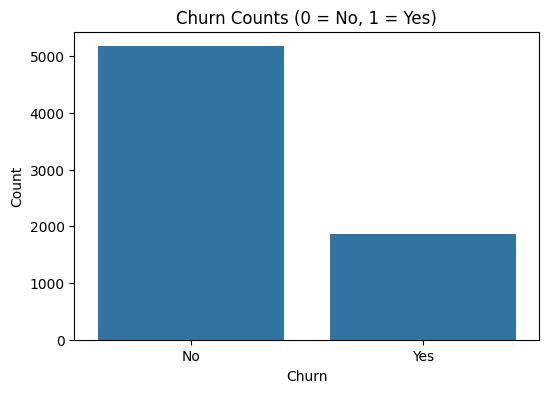

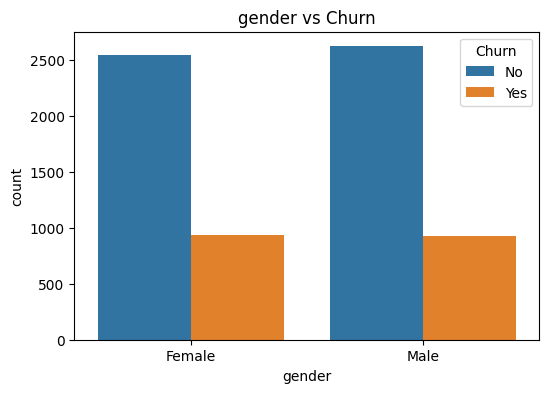

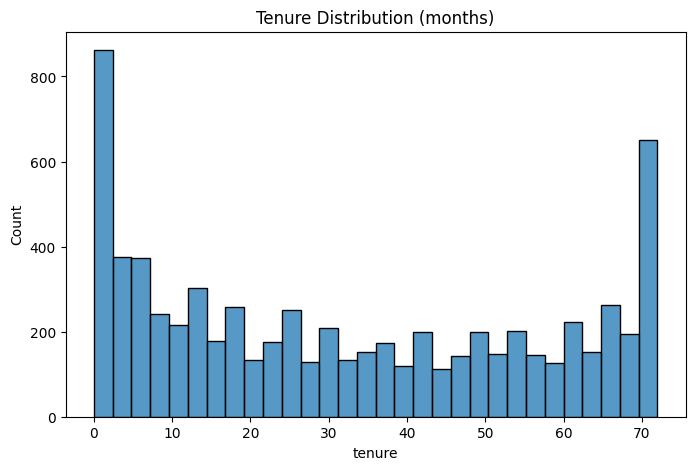

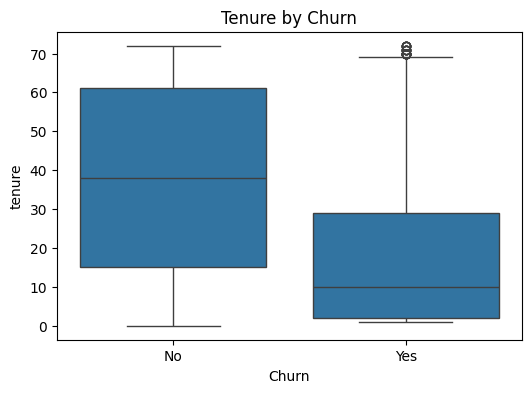

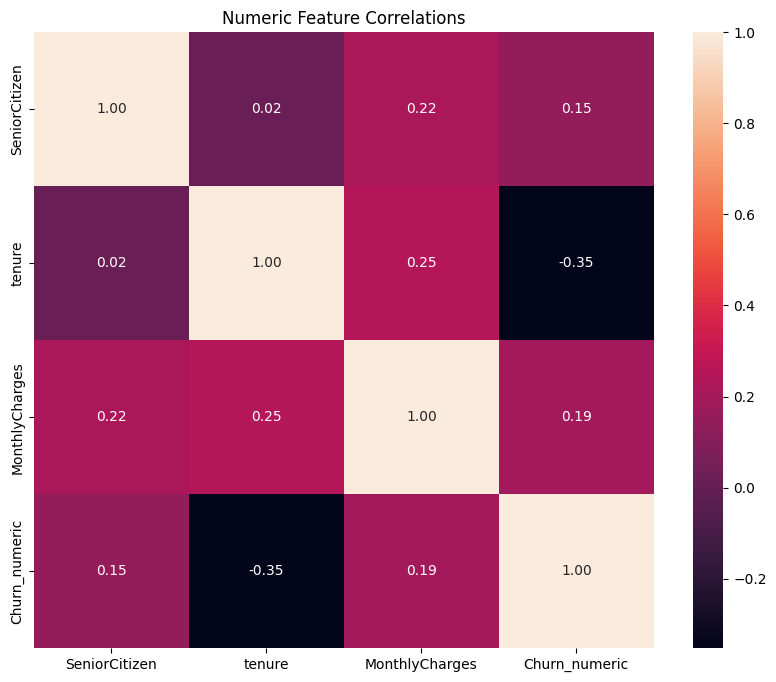

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.impute import SimpleImputer

# Optional: for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    smote_available = False

# ---------- CONFIG ----------
DATA_PATH = "Telco_Customer_Churn_Dataset  (1).csv"  # change if needed
RANDOM_STATE = 42

# ---------- ) Load data ----------
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
# ---------- 2) Exploratory Data Analysis (EDA) ----------
# 2.1 Overall churn rate
target_col = 'Churn'
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})




# Now calculate churn rate
overall_churn_rate = df['Churn_numeric'].mean()
print(f"\nOverall churn rate: {overall_churn_rate:.4f}")

# 2.2 Visualize churn counts
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)

# Now calculate churn rate
overall_churn_rate = df['Churn_numeric'].mean()
print(f"\nOverall churn rate: {overall_churn_rate:.4f}")
plt.title('Churn Counts (0 = No, 1 = Yes)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 2.3 Customer distribution by demographics (if available)
# Example demographics: gender, seniorcitizen, partner, dependents
demo_cols = [c for c in ['gender','seniorcitizen','partner','dependents'] if c in df.columns]
for c in demo_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=c, hue=target_col, data=df)
    plt.title(f'{c} vs Churn')
    plt.show()

# 2.4 Tenure distribution and churn relation
if 'tenure' in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['tenure'], bins=30, kde=False)
    plt.title('Tenure Distribution (months)')
    plt.show()
    # Boxplot tenure vs churn
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y='tenure', data=df)
    plt.title('Tenure by Churn')
    plt.show()

# 2.5 Contract and payment methods vs churn (if present)
for c in ['contract', 'paymentmethod', 'internetservice']:
    if c in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(x=c, hue=target_col, data=df)
        plt.xticks(rotation=45)
        plt.title(f'{c} distribution by churn')
        plt.show()

# 2.6 Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f")
plt.title('Numeric Feature Correlations')
plt.show()


Churn rate by tenure_group:
                   mean  count
tenure_group                 
0-12          0.474382   2186
13-24         0.287109   1024
25-48         0.203890   1594
49-72         0.095132   2239
72+                NaN      0


/tmp/ipython-input-1091049974.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = df.groupby(c)['Churn_numeric'].agg(['mean','count']).sort_values('mean', ascending=False)
/tmp/ipython-input-1091049974.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df.groupby('tenure_group')['Churn_numeric'].mean().reset_index()


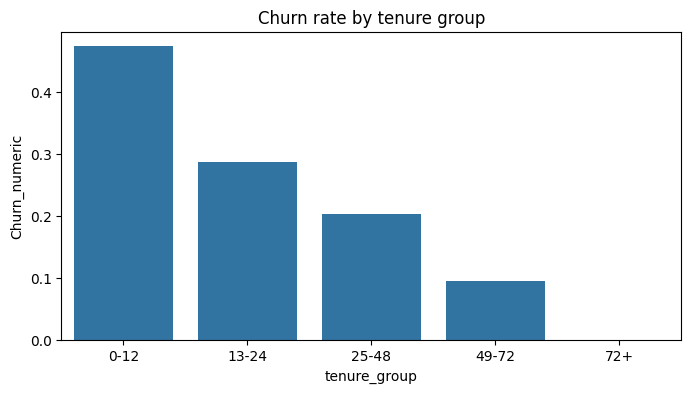

In [ ]:
# ---------- 3) Customer segmentation ----------
# Segment by tenure, monthlycharges, and contract type (simple rules)

# Create monthly charges bins
if 'monthlycharges' in df.columns:
    df['monthly_bin'] = pd.qcut(df['monthlycharges'], q=4, labels=['low','mid','high','very_high'])

# Create tenure bins
if 'tenure' in df.columns:
    max_tenure = df['tenure'].max()
    bins = [0, 12, 24, 48, 72, max_tenure + 1]  # +1 avoids duplicates
    labels = ['0-12','13-24','25-48','49-72', f'{int(max_tenure)}+']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Columns to segment
seg_cols = [c for c in ['monthly_bin','tenure_group','contract'] if c in df.columns]

# Show churn rates across segments
for c in seg_cols:
    seg = df.groupby(c)['Churn_numeric'].agg(['mean','count']).sort_values('mean', ascending=False)
    print(f"\nChurn rate by {c}:\n", seg)

# Visual: churn rate by tenure_group
if 'tenure_group' in df.columns:
    plt.figure(figsize=(8,4))
    churn_by_tenure = df.groupby('tenure_group')['Churn_numeric'].mean().reset_index()
    sns.barplot(x='tenure_group', y='Churn_numeric', data=churn_by_tenure, order=churn_by_tenure['tenure_group'])
    plt.title('Churn rate by tenure group')
    plt.show()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Features to use for modeling: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Numeric features used: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical features used: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
SMOTE available. We will apply after encoding in the pipeline step (demonstration).

Training Logistic Regression...

Logistic Regression Evaluation:
Accuracy: 0.794180269694819
Precision: 0.63125
Recall: 0.5401069518716578
F1: 0.5821325648414986
ROC AUC: 0.8402981218837996

Confusion Matrix:
 [[917 118]
 [172 202]

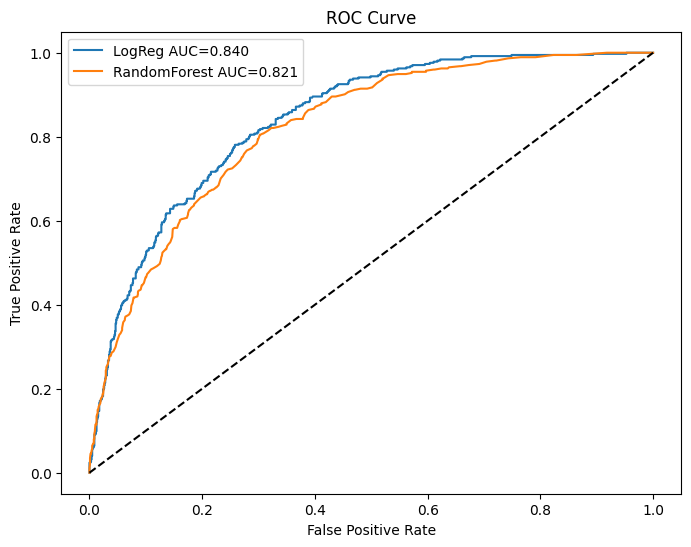


Top feature importances (Random Forest):


,0
tenure,0.102570
MonthlyCharges,0.084003
Contract_Month-to-month,0.033683
PaymentMethod_Electronic check,0.024688
OnlineSecurity_No,0.020583
InternetService_Fiber optic,0.019230
TechSupport_No,0.017191
Contract_Two year,0.016670
OnlineBackup_No,0.016240
OnlineSecurity_Yes,0.015552


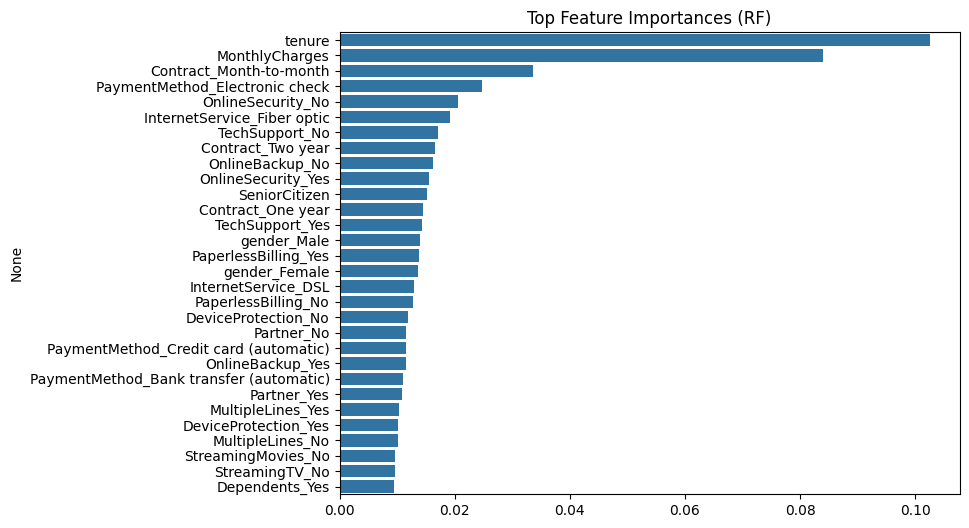

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.impute import SimpleImputer

# Optional: for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    smote_available = False
# ---------- CONFIG ----------
DATA_PATH = "Telco_Customer_Churn_Dataset  (1).csv"  # change if needed
RANDOM_STATE = 42

# ---------- ) Load data ----------
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
# Identify columns that are likely IDs (you can adjust based on your dataset)
target_col="Churn"
id_col_candidates = [c for c in df.columns if 'id' in c.lower()]

# Now define features by dropping IDs and target
drop_cols = id_col_candidates + [target_col]  # or use 'Churn_numeric' if needed
features = [c for c in df.columns if c not in drop_cols]

print("Features to use for modeling:", features)
# ---------- 4) Churn prediction model ----------
# 4.1 Feature selection: pick useful features and encode
# Drop identifiers and target from features
drop_cols = id_col_candidates + [target_col]
features = [c for c in df.columns if c not in drop_cols]

# For demonstration, drop columns that are obviously non-predictive or duplicates
# (Adjust based on your dataset)
# We will build a pipeline to handle numeric and categorical encoding

numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]

print("\nNumeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# Transformer for numeric and categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Prepare X, y
X = df[features].copy()
y = df[target_col].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Optional: handle imbalance with SMOTE
if smote_available:
    print("SMOTE available. We will apply after encoding in the pipeline step (demonstration).")

# 4.2 Build pipelines for Logistic Regression and Random Forest
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

# 4.3 Train Logistic Regression
print("\nTraining Logistic Regression...")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

# 4.4 Evaluate Logistic Regression
print("\nLogistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, pos_label="Yes"))
print("Recall:", recall_score(y_test, y_pred_lr, pos_label="Yes"))
print("F1:", f1_score(y_test, y_pred_lr, pos_label="Yes"))
print("ROC AUC:", roc_auc_score((y_test=="Yes").astype(int), y_proba_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# 4.5 Train Random Forest
print("\nTraining Random Forest...")
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

# Evaluate Random Forest
print("\nRandom Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, pos_label="Yes"))
print("Recall:", recall_score(y_test, y_pred_rf, pos_label="Yes"))
print("F1:", f1_score(y_test, y_pred_rf, pos_label="Yes"))
print("ROC AUC:", roc_auc_score((y_test=="Yes").astype(int), y_proba_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Convert y_test ("Yes"/"No") into binary (Yes=1, No=0)
y_test_binary = (y_test == "Yes").astype(int)

# ROC curves for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary, y_proba_lr, pos_label=1)
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary, y_proba_rf, pos_label=1)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg AUC={auc(fpr_lr, tpr_lr):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest AUC={auc(fpr_rf, tpr_rf):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 4.6 Feature importance from Random Forest
# Extract feature names after OneHot encoding
ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = []
try:
    ohe_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
except Exception:
    # fallback for older scikit-learn
    ohe_feature_names = ohe.get_feature_names(categorical_features).tolist()

num_feature_names = numeric_features
all_feature_names = num_feature_names + ohe_feature_names

rf_clf = pipe_rf.named_steps['clf']
importances = rf_clf.feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(30)
print("\nTop feature importances (Random Forest):")
display(feat_imp)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top Feature Importances (RF)')
plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.impute import SimpleImputer

# ---------- ) Load data ----------
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
# ---------- 5) Customer retention strategies & LTV calculation ----------
# 5.1 Key factors influencing churn (from feature importances)
print("\nSuggested top drivers to investigate further (based on RF importances):")
display(feat_imp.index.tolist()[:10])

# 5.2 Example actions (not code): Offer retention deals for high monthly charges & short tenure customers; target contract upgrades

# 5.3 Calculate a simple Lifetime Value (LTV) per customer (simplified)
# LTV = avg_monthly_profit_per_customer * expected_lifetime_months
# For demo, we assume profit_margin (e.g., 30%) — replace with realistic number
profit_margin = 0.30
if 'monthlycharges' in df.columns and 'tenure' in df.columns:
    # Expected lifetime estimate: current tenure + predicted remaining months for non-churners/average for churners
    df['ltv_simple'] = df['monthlycharges'] * profit_margin * df['tenure']
    print("\nExample LTV stats:")
    display(df['ltv_simple'].describe())

    # Identify high-value customers at risk (top LTV and predicted churn probability)
    # Get predicted churn probability for all customers using the best model (here Random Forest)
    probs = pipe_rf.predict_proba(df[features])[:,1]
    df['churn_prob'] = probs
    # Define high value as top 20% LTV
    high_value_threshold = df['ltv_simple'].quantile(0.80)
    hv_at_risk = df[(df['ltv_simple'] >= high_value_threshold) & (df['churn_prob'] > 0.5)].copy()
    print(f"\nHigh-value customers at risk (LTV >= {high_value_threshold:.2f}, churn_prob>0.5): {hv_at_risk.shape[0]}")
    display(hv_at_risk.head(20))
else:
    print("Cannot compute LTV: monthlycharges or tenure missing.")

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Suggested top drivers to investigate further (based on RF importances):


['tenure',
 'MonthlyCharges',
 'Contract_Month-to-month',
 'PaymentMethod_Electronic check',
 'OnlineSecurity_No',
 'InternetService_Fiber optic',
 'TechSupport_No',
 'Contract_Two year',
 'OnlineBackup_No',
 'OnlineSecurity_Yes']

Cannot compute LTV: monthlycharges or tenure missing.


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


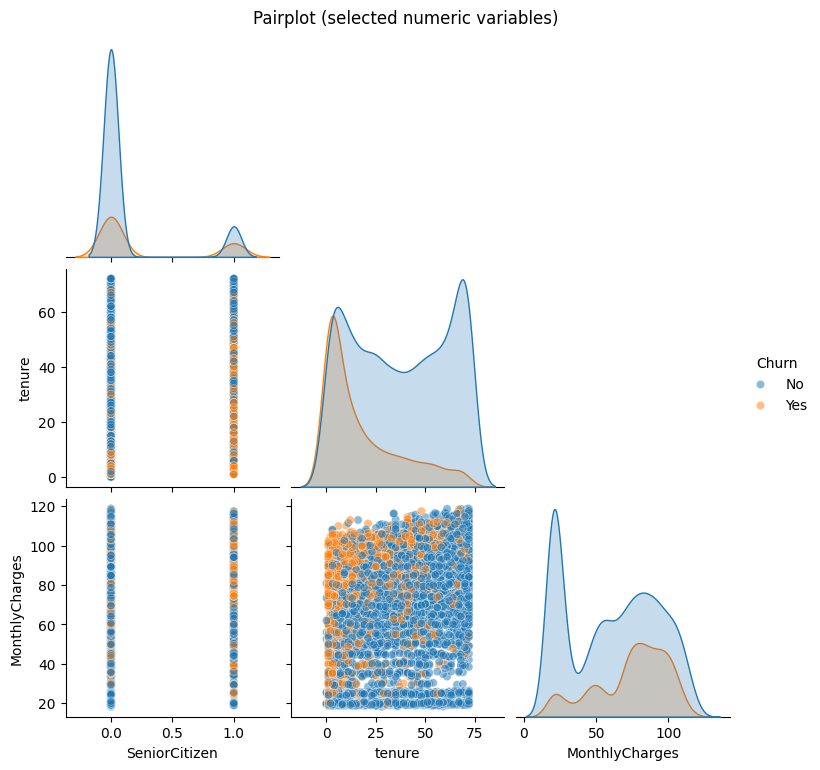

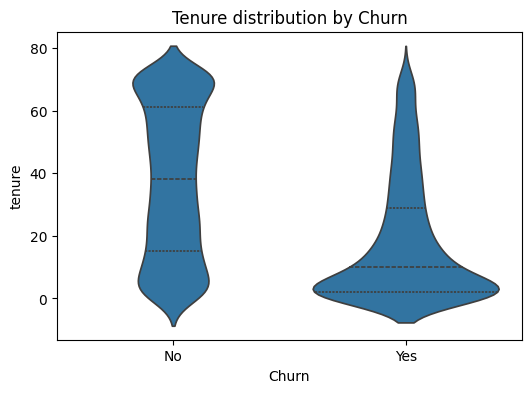


Saved predictions & LTV to telco_predictions_and_ltv.csv (check your working folder)

Notebook/script finished. Review outputs, tune models, and prepare visualizations/report for submission.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.impute import SimpleImputer

# Optional: for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    smote_available = False# ---------- CONFIG ----------
DATA_PATH = "Telco_Customer_Churn_Dataset  (1).csv"  # change if needed
RANDOM_STATE = 42

# ---------- ) Load data ----------
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
# ---------- 6) Additional visualizations ----------
# Boxplots, violin plots, pairplots (limited to smaller sets)
vis_cols = numeric_features[:5]  # choose up to 5 numeric columns for pairplot
if len(vis_cols) >= 2:
    sns.pairplot(df, vars=vis_cols, hue=target_col, corner=True, plot_kws={'alpha':0.5})
    plt.suptitle("Pairplot (selected numeric variables)", y=1.02)
    plt.show()

# Boxplot example for monthly charges by churn
if 'monthlycharges' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y='monthlycharges', data=df)
    plt.title('Monthly Charges by Churn')
    plt.show()

# Violin plot example for tenure by churn
if 'tenure' in df.columns:
    plt.figure(figsize=(6,4))
    sns.violinplot(x=target_col, y='tenure', data=df, inner='quartile')
    plt.title('Tenure distribution by Churn')
    plt.show()

# ---------- Save outputs (optional) ----------
# Save model predictions and LTV to CSV for submission/reporting
output_cols = id_col_candidates + ['churn_prob', 'ltv_simple'] if id_col_candidates else ['churn_prob','ltv_simple']
# Filter only columns that exist
output_cols = [c for c in output_cols if c in df.columns]
if output_cols:
    out_df = df[output_cols]
    out_path = "telco_predictions_and_ltv.csv"   # saves in current directory
out_df.to_csv(out_path, index=False)
print(f"\nSaved predictions & LTV to {out_path} (check your working folder)")
print("\nNotebook/script finished. Review outputs, tune models, and prepare visualizations/report for submission.")